# MODELISATION DU COMPORTEMENT D'ARBITRAGE EN ASSURANCE VIE

In [1]:
!pip install openpyxl -q
!pip install yahoo_fin --upgrade -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timezone
from yahoo_fin.stock_info import get_data

In [3]:
import os
os.getcwd()

'C:\\Users\\oseez'

In [4]:
base = pd.read_excel("Base_ENSAE_2021_corr.xlsx", sheet_name="Données")

In [5]:
base.head()

,n_sous,Anmois_eff_sous,Anmois_eff_fisc,TOP_2TETE,COD_BEN_DC,COD_BEN_VIE,TOP_BEN_ACPT,MTTC_PRI_REG_ORIG,MT_PRS_VRS_ORIG,MTTC_PRI_INV_ANN,...,PM_UC,PM_FG,montant_corr,NB_UC_corr,montant_frais_corr,mtt_rachat_corr,mtt_vers_corr,mtt_vers_ann_corr,mtt_arbs_corr,mtt_arbe_corr
0,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ARBITRAGES SUR LE FOND GENERAL

In [6]:
#Base de données des opérations sur le fond Général (toutes les opérations incluant le FG)
base_operation_FG = base.dropna(subset = ['CD_TYPE_SUP'])[base.dropna(subset = ['CD_TYPE_SUP'])['CD_TYPE_SUP'].str.contains('FG')]

#Variables temporelles d'arbitrage (année et mois)
base_operation_FG['annee_operation'] =  base_operation_FG['Anmois_operation'].astype(str).str.slice(0, 4)
base_operation_FG['mois_operation'] =  base_operation_FG['Anmois_operation'].astype(str).str.slice(4, 6)

In [7]:
# regroupement par contrats et par Anmois_operation
base_operation_regroupee_FG = base_operation_FG.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

In [8]:
base_operation_FG["operation"].unique()

array(['rachat partiel', 'Arbitrages entrants du FG',
       'Arbitrages sortants du FG', 'primes programmées',
       'rachat programmé', 'décès', 'versement libre', 'PS sur décès',
       'rachat total'], dtype=object)

In [9]:
#Calcul des PM_FG actualisées après chaque opération impliquant le FG
### Pour chaque opération qui inclut le Fond G, on actualise la valeur de la PM après cette opération
base_operation_FG["PM_FG_actualisee"]=np.nan

for (contrat, date), groupe in base_operation_regroupee_FG:
    liste_index = list(groupe.index)
    base_operation_FG.loc[[liste_index[-1]], "PM_FG_actualisee"] = base_operation_FG.loc[[liste_index[-1]], "PM_FG"].values[0] - base_operation_FG.loc[[liste_index[-1]], "montant_corr"].values[0]
    if len(groupe)  >= 2 : # Au cas où il y'a eu au moins deux mouvements concernant le fonds FG
        liste_index.reverse()
        l = len(liste_index)
        for position, i in enumerate(liste_index):
            if position == 0:
                continue
            else: 
                for index, ligne in groupe.iterrows():
                    if index == i:
                        montant_operation = ligne['montant_corr']
                        base_operation_FG.loc[[index], "PM_FG_actualisee"] = base_operation_FG.loc[[liste_index[position-1]], "PM_FG_actualisee"].values[0] - montant_operation
        

In [10]:
base_operation_FG[['n_sous','Anmois_operation', 'operation', 'PM_FG','montant_corr','PM_FG_actualisee']].tail(20)

,n_sous,Anmois_operation,operation,PM_FG,montant_corr,PM_FG_actualisee
118914,9458,202112.0,Arbitrages sortants du FG,113235.576015,-5854.02,119089.596015
118955,9463,202109.0,Arbitrages sortants du FG,29281.679346,-9594.17,38875.849346
119072,9473,202110.0,Arbitrages sortants du FG,7124.728836,-3032.88,10157.608836
119084,9475,202105.0,Arbitrages sortants du FG,35387.958173,-1849.08,37237.038173
119147,9480,202106.0,versement libre,2487.687986,2539.80,-52.112014
119226,9488,202101.0,Arbitrages sortants du FG,60670.960189,-3163.69,63834.650189
119228,9488,202103.0,Arbitrages sortants du FG,57705.482418,-3006.55,60712.032418
119397,9502,202104.0,versement libre,42561.833900,17430.00,25131.833900
119467,9507,202101.0,primes programmées,69102.069125,100.00,69002.069125
119468,9507,202102.0,primes programmées,69102.069125,100.00,69002.069125


In [11]:
base_operation_FG[['n_sous','Anmois_operation', 'operation', 'PM_FG','montant_corr','PM_FG_actualisee']].head(20)

,n_sous,Anmois_operation,operation,PM_FG,montant_corr,PM_FG_actualisee
13,2,202102.0,rachat partiel,129737.086302,-12209.33,142139.416302
14,2,202102.0,rachat partiel,129737.086302,-193.00,129930.086302
53,5,202104.0,Arbitrages entrants du FG,10378.395674,10354.23,24.165674
61,5,202111.0,rachat partiel,9214.572337,-1129.03,10343.602337
79,7,202102.0,Arbitrages sortants du FG,0.000000,-24371.62,24371.620000
114,10,202101.0,primes programmées,19721.176295,75.84,19645.336295
115,10,202102.0,primes programmées,19820.853398,75.84,19745.013398
116,10,202103.0,primes programmées,19920.104649,75.84,19844.264649
117,10,202104.0,primes programmées,19983.972725,75.84,19908.132725
118,10,202105.0,primes programmées,20065.856916,75.84,19990.016916


In [12]:
#Base des arbitrages sortants du FG (tous les arbitrages sortant du FG)
base_arbitrage_FG = base_operation_FG.dropna(subset = ['operation'])[base_operation_FG.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages sortants du FG')]
#Base d'arbitrages regroupée
base_arbitrage_regroupee_FG = base_arbitrage_FG.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

In [13]:
# Calcul des taux d'arbitrages
base_arbitrage_FG["r_FG"]=0
for (contrat, date), groupe in base_arbitrage_regroupee_FG:
    for index, ligne in groupe.iterrows():
        colonne_operation = ligne['operation']
        if colonne_operation == 'Arbitrages sortants du FG':
            montant_operation = ligne['mtt_arbs_corr'] * (-1)
            base_arbitrage_FG.loc[[index], "r_FG"] = montant_operation/base_arbitrage_FG.loc[[index], "PM_FG_actualisee"].values[0]
            
        

In [14]:
base_arbitrage_FG.head(20)

,n_sous,Anmois_eff_sous,Anmois_eff_fisc,TOP_2TETE,COD_BEN_DC,COD_BEN_VIE,TOP_BEN_ACPT,MTTC_PRI_REG_ORIG,MT_PRS_VRS_ORIG,MTTC_PRI_INV_ANN,...,montant_frais_corr,mtt_rachat_corr,mtt_vers_corr,mtt_vers_ann_corr,mtt_arbs_corr,mtt_arbe_corr,annee_operation,mois_operation,PM_FG_actualisee,r_FG
79,7,197706,197705,0,1,1,0,288296.01,229853.44,0.00,...,0.0,0.0,0.0,0.0,-24371.62,0.0,2021,02,24371.620000,1.000000
125,10,197803,197802,0,2,1,0,170006.59,9147.35,762.01,...,0.0,0.0,0.0,0.0,-20342.53,0.0,2021,10,20431.154841,0.995662
179,16,197812,197811,0,1,1,0,412297.57,0.00,0.00,...,0.0,0.0,0.0,0.0,-52139.56,0.0,2021,04,522578.280241,0.099774
264,24,197812,197812,0,1,1,0,298930.65,9147.35,0.00,...,0.0,0.0,0.0,0.0,-59695.05,0.0,2021,03,427404.416491,0.139669
272,24,197812,197812,0,1,1,0,298930.65,9147.35,0.00,...,0.0,0.0,0.0,0.0,-29373.86,0.0,2021,09,368138.785935,0.079790
391,34,197912,197912,0,1,1,0,357223.98,0.00,366.90,...,0.0,0.0,0.0,0.0,-30016.89,0.0,2021,06,435285.781450,0.068959
688,58,198112,198112,0,1,1,0,553245.19,180214.05,0.00,...,0.0,0.0,0.0,0.0,-120635.08,0.0,2021,05,549485.086063,0.219542
943,80,198212,198212,0,1,1,0,308445.89,30624.84,0.00,...,0.0,0.0,0.0,0.0,-39413.71,0.0,2021,01,263356.443865,0.149659
947,80,198212,198212,0,1,1,0,308445.89,30624.84,0.00,...,0.0,0.0,0.0,0.0,-29046.33,0.0,2021,03,224007.073352,0.129667
1013,85,198312,198312,0,1,1,0,234492.66,92354.00,35600.59,...,0.0,0.0,0.0,0.0,-7702.57,0.0,2021,07,38710.386307,0.198979


In [15]:
#Mensualisation des taux 
taux_mensuels = pd.DataFrame()
for (contrat, date), groupe in base_arbitrage_regroupee_FG:
    prd_scl = np.dot(groupe["r_FG"], groupe["PM_FG_actualisee"])
    somme = (np.sum(groupe["PM_FG_actualisee"]))
    taux = 1 - (1 - prd_scl/somme)**30
    ligne = pd.DataFrame({'n_sous' : [contrat], 'Anmois_operation' : [int(date)], "r_FG_m" : [taux]})
    taux_mensuels = pd.concat([taux_mensuels, ligne])

In [16]:
taux_mensuels.head(10)

,n_sous,Anmois_operation,r_FG_m
0,7,202102,1.000000
0,10,202110,1.000000
0,16,202104,0.957288
0,24,202103,0.989036
0,24,202109,0.917471
0,34,202106,0.882763
0,58,202105,0.999410
0,80,202101,0.992277
0,80,202103,0.984492
0,85,202107,0.998714


In [17]:
base_arbitrage_FG[['n_sous','Anmois_operation', 'operation', 'PM_FG','montant_corr','PM_FG_actualisee', 'r_FG']].head(5)

,n_sous,Anmois_operation,operation,PM_FG,montant_corr,PM_FG_actualisee,r_FG
79,7,202102.0,Arbitrages sortants du FG,0.000000,-24371.62,24371.620000,1.000000
125,10,202110.0,Arbitrages sortants du FG,88.624841,-20342.53,20431.154841,0.995662
179,16,202104.0,Arbitrages sortants du FG,470438.720241,-52139.56,522578.280241,0.099774
264,24,202103.0,Arbitrages sortants du FG,367709.366491,-59695.05,427404.416491,0.139669
272,24,202109.0,Arbitrages sortants du FG,338764.925935,-29373.86,368138.785935,0.079790


In [18]:
#Regroupement de la base des taux mensuels
arbitrage_m_regroupee_FG = taux_mensuels.groupby(by= 'n_sous', as_index = False)

#Annualisation des taux 
taux_annuels = pd.DataFrame()
for contrat, groupe in arbitrage_m_regroupee_FG:
    taux = 1 - (np.prod(1 - groupe["r_FG_m"])) 
    ligne = pd.DataFrame({'n_sous' : [contrat], "r_FG_a" : [taux]})
    taux_annuels = pd.concat([taux_annuels, ligne])

In [91]:
taux_annuels.isna().sum()

n_sous    0
r_FG_a    0
dtype: int64

In [20]:
#Fusion des bases pour pouvoir faire correspondre à chaque contrat son taux d'arbitrage mensualisé et annualisé
#Fusion des bases pour pouvoir faire correspondre à chaque contrat son taux d'arbitrage mensualisé et annualisé
base_updte = pd.merge(base, taux_mensuels, how="left", on=["n_sous", "Anmois_operation"], suffixes=(None, None))
base_updte = pd.merge(base_updte, taux_annuels, how="left", on="n_sous", suffixes=(None, None))
base_updte['r_FG_a'] = base_updte['r_FG_a'].fillna(0)
base_updte['r_FG_m'] = base_updte['r_FG_m'].fillna(0)

In [21]:
#Base qui recense tous les arbitrages sortant du FG avec le calcul du taux d'arbitrage annualisé
base_arbitrage_FG_update = base_arbirtrages_all.dropna(subset = ['operation'])[base_arbirtrages_all.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages sortants du FG')]
#Base qui recense tous contrats multi-suppots
base_multisupport = base_updte.dropna(subset = ['support'])[base_updte.dropna(subset = ['support'])['support'].str.contains('Multi-supports avec FG')]
base_multisupport['r_FG_a'] = base_multisupport['r_FG_a'].fillna(0)

NameError: name 'base_arbirtrages_all' is not defined

In [ ]:
base_multisupport['r_FG_a'].nunique()

# DESCRIPTION DE LA BASE DE DONNEES 

### 1. Aperçu général de la base de données :

In [22]:
base = pd.read_excel("Base_ENSAE_2021_corr.xlsx", sheet_name="Données")
base

KeyboardInterrupt: 

#### Nombre total d'observations et de variables :

In [23]:
print(base.shape)
print("\nListe des varaibles de la base :\n")
base.columns.tolist()

(119479, 104)

Liste des varaibles de la base :



['n_sous',
 'Anmois_eff_sous',
 'Anmois_eff_fisc',
 'TOP_2TETE',
 'COD_BEN_DC',
 'COD_BEN_VIE',
 'TOP_BEN_ACPT',
 'MTTC_PRI_REG_ORIG',
 'MT_PRS_VRS_ORIG',
 'MTTC_PRI_INV_ANN',
 'MTTC_PRI_INV_AP',
 'MTTC_PRI_ECH_NRAC',
 'MT_VRAC_SOUS',
 'COD_POS_SOUS',
 'COD_VRS',
 'Anmois_eff_mvt',
 'Anmois_ter_sous',
 'MTTC_PP_ACTU',
 'MBRUT_MVT',
 'COD_MVT_SC',
 'ID_PRD',
 'TOP_MEG',
 'TOP_NUPROP',
 'TOP_COSOUS',
 'TOP_K_DEMBRT',
 'TOP_PROCU',
 'MTTC_PRI_FISC98',
 'MT_VAC_FISC98',
 'DUR_SOUS',
 'Anmois_sign_sous',
 'TOP_DEROG_FRAIS_ARB',
 'TOP_CONTRAT_DIVERSIFIE',
 'MT_CGT_REEL',
 'COD_TYP_MANDAT',
 'TOP_HANDICAP',
 'reseau_fin',
 'Anmois_arrete',
 'CODPTT',
 'COD_CSP',
 'COD_FIS',
 'COD_SIT_FAM',
 'NB_ENF_CHR',
 'Anmois_DC',
 'COD_POS_CLI',
 'COD_T_CLI',
 'COD_CAT_CLI',
 'TOP_2ASS',
 'BDIS',
 'TOP_GES_PAR',
 'TOP_RENT',
 'TOP_SICAV',
 'TOP_GAR',
 'TOP_ASSU',
 'TOP_ASSU_OTO',
 'TOP_CPT_OPT',
 'TOP_ISF',
 'TOP_DIVS',
 'COD_PAYS',
 'TOP_VIE_ENT',
 'L_VIL_NAIS',
 'COD_INSEE',
 'COD_PTT_COUR',
 'COD_PAYS

#### Type de données pour chaque variable : 

In [24]:
base.dtypes

n_sous                 int64
Anmois_eff_sous        int64
Anmois_eff_fisc        int64
TOP_2TETE              int64
COD_BEN_DC             int64
                      ...   
mtt_rachat_corr      float64
mtt_vers_corr        float64
mtt_vers_ann_corr    float64
mtt_arbs_corr        float64
mtt_arbe_corr        float64
Length: 104, dtype: object

#### Statistiques descriptives de base :

In [25]:
base.describe()

,n_sous,Anmois_eff_sous,Anmois_eff_fisc,TOP_2TETE,COD_BEN_DC,COD_BEN_VIE,TOP_BEN_ACPT,MTTC_PRI_REG_ORIG,MT_PRS_VRS_ORIG,MTTC_PRI_INV_ANN,...,PM_UC,PM_FG,montant_corr,NB_UC_corr,montant_frais_corr,mtt_rachat_corr,mtt_vers_corr,mtt_vers_ann_corr,mtt_arbs_corr,mtt_arbe_corr
count,119479.000000,119479.000000,119479.000000,119479.000000,119479.000000,119479.000000,119479.000000,1.194790e+05,1.194790e+05,1.194790e+05,...,2.255900e+04,2.255900e+04,2.255900e+04,22559.000000,22559.000000,2.255900e+04,2.255900e+04,22559.000000,2.255900e+04,2.255900e+04
mean,4629.559019,199468.878581,199460.947673,0.018045,3.779158,1.659915,0.008520,2.118239e+05,9.958422e+04,1.968457e+03,...,2.221262e+05,1.965471e+05,-1.825788e+02,-15.736351,2.531906,-1.302299e+03,1.170479e+03,-48.221890,-1.301531e+04,1.301530e+04
std,2783.619962,531.798581,529.609481,0.133115,4.468540,0.576264,0.091912,7.265020e+05,5.952317e+05,3.805790e+04,...,8.662484e+05,3.276086e+05,2.866987e+05,3514.859207,34.679868,1.665036e+04,1.920308e+04,2103.595544,2.012922e+05,2.017363e+05
min,1.000000,197406.000000,197404.000000,0.000000,1.000000,1.000000,0.000000,1.519000e+01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-2.358857e+07,-473893.155500,0.000000,-1.229005e+06,-1.067100e+02,-203700.000000,-2.358857e+07,0.000000e+00
25%,2177.000000,199210.000000,199210.000000,0.000000,1.000000,1.000000,0.000000,1.067133e+04,0.000000e+00,0.000000e+00,...,2.657818e+04,2.607521e+04,-6.222380e+03,-13.429200,0.000000,0.000000e+00,0.000000e+00,0.000000,-4.441180e+03,0.000000e+00
50%,4501.000000,199309.000000,199309.000000,0.000000,1.000000,2.000000,0.000000,4.001781e+04,0.000000e+00,0.000000e+00,...,9.818383e+04,1.018850e+05,3.079000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
75%,7077.000000,199612.000000,199609.000000,0.000000,4.000000,2.000000,0.000000,1.935875e+05,3.609862e+04,0.000000e+00,...,2.139210e+05,2.371641e+05,5.043650e+03,1.619800,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,4.375895e+03
max,9507.000000,201909.000000,201909.000000,1.000000,16.000000,6.000000,1.000000,2.815136e+07,2.860689e+07,2.650001e+06,...,3.600573e+07,6.860224e+06,2.358857e+07,131096.022300,2750.000000,0.000000e+00,1.200000e+06,106.710000,0.000000e+00,2.358857e+07


### 3. Analyse des valeurs manquantes :

#### Identifiez les variables avec des valeurs manquantes

In [26]:
missing_values = base.isnull().sum()
print("\n Analyse des valeurs manquantes : ")
print(missing_values[missing_values > 0])


 Analyse des valeurs manquantes : 
DUR_SOUS               42910
TOP_GAR               101256
TOP_ASSU                3005
TOP_ASSU_OTO             213
TOP_ISF                 2706
TOP_DIVS                 798
COD_PAYS              117194
TOP_VIE_ENT              157
L_VIL_NAIS               288
COD_PTT_COUR           69348
COD_PAYS_COUR          69348
TOP_NPAI_COUR            522
TOP_EP_PROG            25894
TOP_VRS_COMPL          28791
SOUSCRIPTEUR           24899
Anmois_operation       96902
operation              96902
CD_TYPE_SUP            96902
TX_FRS_ARB             96959
montant                96902
NB_UC                  96902
montant_frais          96902
mtt_rachat             96902
mtt_vers               96902
mtt_vers_ann           96902
mtt_arbs               96902
à°                     96902
PM_UC                  96920
PM_FG                  96920
montant_corr           96920
NB_UC_corr             96920
montant_frais_corr     96920
mtt_rachat_corr        96920
mtt_ver

ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of labels (104).

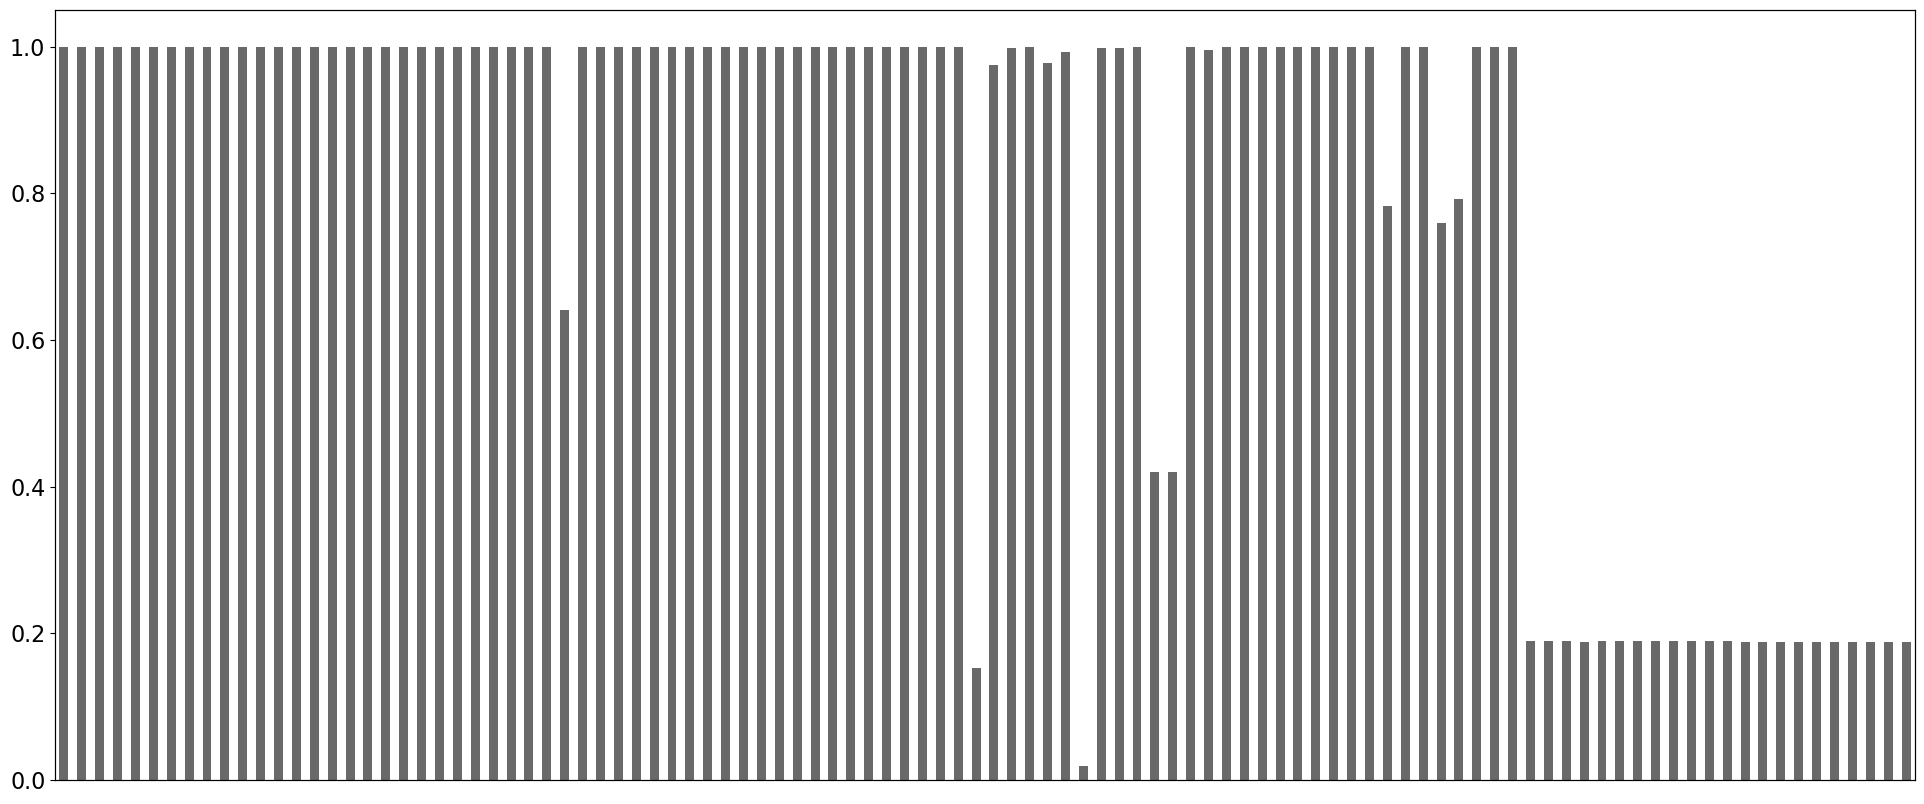

In [27]:
import missingno as mso
mso.bar(base)
mso.matrix(base)

In [ ]:
mso.matrix(base)

Ce pendant nous avons le nombre de contrats différents suivant:

In [28]:
len(base['n_sous'].unique())

9507

### Répartition du portefeuille suivant le type de support

Nous nous intéressons qu'aux contrats multisupports et nous avons la répartion suivant selon le type de support :

In [29]:
base_support=base[['n_sous','support']]
p=base_support.drop_duplicates(subset="n_sous")
p.groupby(by="support").count()

,n_sous
support,
FG pur,3254
Multi-supports avec FG,4629
UC pures,1624


Sur les 9507 contrats de la base de données nous allons nous restreindre aux 4626 contrats Multisupports définis comme suit:

In [30]:
#Base qui recense tous contrats multi-suppots
base_multisupport = base_updte.dropna(subset = ['support'])[base_updte.dropna(subset = ['support'])['support'].str.contains('Multi-supports avec FG')]
base_multisupport['r_FG_a'] = base_multisupport['r_FG_a'].fillna(0)

# Définition des variables de durées (âge et ancienneté)
base_multisupport['annee_sign_sous'] =  base_multisupport['Anmois_sign_sous'].astype(str).str.slice(0, 4)
base_multisupport['mois_sign_sous'] =  base_multisupport['Anmois_sign_sous'].astype(str).str.slice(4, 6)
base_multisupport['annee_sign_sous'] = base_multisupport['annee_sign_sous'].astype(int)
base_multisupport['mois_sign_sous'] = base_multisupport['mois_sign_sous'].astype(int)
base_multisupport['anciennete'] = 2021 - base_multisupport['annee_sign_sous']

base_multisupport['annee_nais'] =  base_multisupport['Anmois_naissance'].astype(str).str.slice(0, 4)
base_multisupport['annee_nais'] = base_multisupport['annee_nais'].astype(int)
base_multisupport['age'] = 2021 - base_multisupport['annee_nais']

In [31]:
base_multisupport.shape

(63280, 111)

En se restraingnant uniquement aux contrats ayant fait l'objet d'arbitrage, nous avons :

In [32]:
base_multisupport_arbitrage=base_multisupport.dropna(subset = ['operation'])[base_multisupport.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages')]
base_multisupport_arbitrage.shape

(13445, 111)

In [ ]:
base_multisupport_arbitrage=base_multisupport.dropna(subset = ['operation'])[base_multisupport.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages')]



## Nombre de contrats arbitrant par mois

In [33]:
comptage=base_multisupport_arbitrage[['n_sous','support','Anmois_operation','operation','CD_TYPE_SUP','montant_corr','anciennete','age']]

In [34]:
comptage_NU=base_multisupport_arbitrage[['n_sous','Anmois_operation']]
contrat_arbitre = comptage_NU.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre.rename(columns={'n_sous': 'Nombre de contrats arbitrants'}, inplace=True)
contrat_arbitre

,Anmois_operation,Nombre de contrats arbitrants
0,202101.0,427
1,202102.0,449
2,202103.0,740
3,202104.0,480
4,202105.0,422
5,202106.0,564
6,202107.0,299
7,202108.0,238
8,202109.0,551
9,202110.0,345


Au total sur notre portefeuille le nombre total de contrats qui ont arbitré est de :

In [35]:
N5=len(np.unique(comptage_NU['n_sous']))
N5

1734

### Nombre de contrats qui ont effectué 1, 2, 3 ou plus 4 arbitrages suivant les mois

In [36]:
# On détermine de prime à bord le nombre de d'opérations d'arbitrage (EU vers UC, UC vers EU, UC vers UC) 
# par mois de chaque contrat 
import math
contrat_mois = comptage.groupby(by=['n_sous','Anmois_operation'], as_index=False).count()
contrat_mois['operation']=(contrat_mois['operation']/2).apply(lambda x: math.ceil(x))
# Chaque contrat arbitre chaque mois 1, 2, 3 ou 4 fois 
contrat_mois['operation'].unique()

array([1, 2, 3, 4], dtype=int64)

In [37]:
# Utiliser pour évaluer le nombre de contrat total arbitrant 1, 2, 3 ou plus de 4 fois sur l'année
p=contrat_mois.groupby(by=['n_sous'], as_index=False).sum()

Ainsi le nombre d'arbitrage par contrat et par mois vari d'un contrat à l'autre de 1 à plus 4

#### Pour les contrats arbitrant une seul fois :

In [38]:
contrat_mois_1=contrat_mois[contrat_mois['operation']==1]
contrat_arbitre_1 = contrat_mois_1.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre_1=contrat_arbitre_1[['Anmois_operation','n_sous']]
contrat_arbitre_1.rename(columns={'n_sous': 'Nombre de contrats arbitrants 1 fois'}, inplace=True)
contrat_arbitre_1

,Anmois_operation,Nombre de contrats arbitrants 1 fois
0,202101.0,360
1,202102.0,342
2,202103.0,215
3,202104.0,337
4,202105.0,291
5,202106.0,308
6,202107.0,238
7,202108.0,211
8,202109.0,481
9,202110.0,273


#### Total des contrats qui arbitrent 1 fois sur l'année :

Dans le portefeuille le nombre de contrat ayant arbitré 1 fois aucours de l'année est de :

In [39]:
N1= (p[p['operation']==1])['n_sous'].count()
N1

495

    ### Pour les contrats arbitrants deux fois :

In [40]:
contrat_mois_2=contrat_mois[contrat_mois['operation']==2]
contrat_arbitre_2 = contrat_mois_2.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre_2=contrat_arbitre_2[['Anmois_operation','n_sous']]
contrat_arbitre_2.rename(columns={'n_sous': 'Nombre de contrats arbitrants 2 fois'}, inplace=True)
contrat_arbitre_2

,Anmois_operation,Nombre de contrats arbitrants 2 fois
0,202101.0,66
1,202102.0,95
2,202103.0,504
3,202104.0,137
4,202105.0,126
5,202106.0,102
6,202107.0,57
7,202108.0,25
8,202109.0,68
9,202110.0,69


Dans le portefeuille le nombre de contrat ayant arbitré 2 fois aucours de l'année est de :

In [41]:
N2= (p[p['operation']==2])['n_sous'].count()
N2

312

#### Pour les contrats arbitrant trois fois :

In [42]:
contrat_mois_3=contrat_mois[contrat_mois['operation']==3]
contrat_arbitre_3 = contrat_mois_3.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre_3=contrat_arbitre_3[['Anmois_operation','n_sous']]
contrat_arbitre_3.rename(columns={'n_sous': 'Nombre de contrats arbitrants 3 fois'}, inplace=True)
contrat_arbitre_3

,Anmois_operation,Nombre de contrats arbitrants 3 fois
0,202101.0,1
1,202102.0,11
2,202103.0,21
3,202104.0,6
4,202105.0,5
5,202106.0,154
6,202107.0,4
7,202108.0,2
8,202109.0,2
9,202110.0,3


Dans le portefeuille le nombre de contrat ayant arbitré 3 fois aucours de l'année est de : 

In [43]:
N3= (p[p['operation']==3])['n_sous'].count()
N3

151

#### Pour les contrats arbitrant plus de quatre fois :

In [44]:
contrat_mois_4=contrat_mois[contrat_mois['operation']>=4]
contrat_arbitre_4 = contrat_mois_4.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre_4=contrat_arbitre_4[['Anmois_operation','n_sous']]
contrat_arbitre_4.rename(columns={'n_sous': 'Nombre de contrats arbitrants 4 fois'}, inplace=True)
contrat_arbitre_4

,Anmois_operation,Nombre de contrats arbitrants 4 fois
0,202102.0,1


Dans le portefeuille le nombre de contrat ayant arbitré plus de 4 fois aucours de l'année est de : (Notons qu'il y'a des contrats qui ont arbitré plus de 20 fois)

In [45]:
N4=(p[p['operation']>=4])['n_sous'].count()
N4

776

### Pour ce qui est du nombre Total d'opérations d'arbitrages par mois nous avons :

In [46]:
Nb_contrat =contrat_mois.groupby(by=['Anmois_operation'], as_index=False).sum()
Nb_contrat=Nb_contrat[['Anmois_operation','operation']]
Nb_contrat.rename(columns={'operation': 'Nombre d arbitrages'}, inplace=True)
Nb_contrat

,Anmois_operation,Nombre d arbitrages
0,202101.0,495
1,202102.0,569
2,202103.0,1286
3,202104.0,629
4,202105.0,558
5,202106.0,974
6,202107.0,364
7,202108.0,267
8,202109.0,623
9,202110.0,420


Nombre Total d'opérations arbitrages sur l'année :

In [47]:
N6=Nb_contrat['Nombre d arbitrages'].sum()
N6

7297

### Maintenant nous avons les statitiques du portefeuille en nombre d'arbitrage suivants : 

In [48]:
dataframes=[contrat_arbitre_1,contrat_arbitre_2,contrat_arbitre_3,contrat_arbitre_4,contrat_arbitre,Nb_contrat]
stat = dataframes[0]
for df in dataframes[1:]:
    stat = pd.merge(stat, df, on='Anmois_operation', how='outer')
stat.fillna(0, inplace=True)
stat =stat.astype(int)
#Convertir la colonne Anmois_opération
from datetime import datetime
stat['Anmois_operation'] = pd.to_datetime(stat['Anmois_operation'], format='%Y%m')
stat['Anmois_operation'] = stat['Anmois_operation'].dt.strftime('%B %Y')
stat['Anmois_operation'] = stat['Anmois_operation'].astype(str)
stat.loc[len(stat)] = ['ENSEMBLE',N1,N2,N3,N4,N5,N6]
stat = stat.set_index('Anmois_operation')
stat

,Nombre de contrats arbitrants 1 fois,Nombre de contrats arbitrants 2 fois,Nombre de contrats arbitrants 3 fois,Nombre de contrats arbitrants 4 fois,Nombre de contrats arbitrants,Nombre d arbitrages
Anmois_operation,,,,,,
January 2021,360,66,1,0,427,495
February 2021,342,95,11,1,449,569
March 2021,215,504,21,0,740,1286
April 2021,337,137,6,0,480,629
May 2021,291,126,5,0,422,558
June 2021,308,102,154,0,564,974
July 2021,238,57,4,0,299,364
August 2021,211,25,2,0,238,267
September 2021,481,68,2,0,551,623


Ainsi, 1734 contrats ont été à l’origine des 7297 mouvements d’arbitrages enregistrés, et sur l'année 2021 seuls 495 contrats du portefeuille n’ont effectué qu’un seul arbitrage.

### Mouvement d'arbitrage de EU vers UC

#### Nombre d'arbitrages par EU -> UC

In [49]:
#arbitrage_EU=comptage[comptage['operation']=='Arbitrages sortants du FG']
#Nb_contrat_mois_EU = arbitrage_EU.groupby('Anmois_operation')['operation'].count()
#Nb_contrat_mois_EU

In [50]:
arbitrage_EU=comptage[comptage['operation']=='Arbitrages sortants du FG']
contrat_mois_EU =arbitrage_EU.groupby(by=['n_sous','Anmois_operation'], as_index=False).count()
Nb_contrat_mois_EU=contrat_mois_EU.groupby(by=['Anmois_operation'], as_index=False).sum()
Nb_contrat_mois_EU=Nb_contrat_mois_EU[['Anmois_operation','operation']]
Nb_contrat_mois_EU.rename(columns={'operation': 'Nombre d arbitrages EU->UC'}, inplace=True)
Nb_contrat_mois_EU

,Anmois_operation,Nombre d arbitrages EU->UC
0,202101.0,91
1,202102.0,224
2,202103.0,118
3,202104.0,90
4,202105.0,65
5,202106.0,266
6,202107.0,68
7,202108.0,46
8,202109.0,46
9,202110.0,63


### Mouvement d'arbitrage de UC vers EU

#### Nombre d'arbitrages par EU -> UC

In [59]:
arbitrage_UC=comptage[comptage['operation']=='Arbitrages entrants du FG']
contrat_mois_UC =arbitrage_UC.groupby(by=['n_sous','Anmois_operation'], as_index=False).count()
Nb_contrat_mois_UC=contrat_mois_UC.groupby(by=['Anmois_operation'], as_index=False).sum()
Nb_contrat_mois_UC=Nb_contrat_mois_UC[['Anmois_operation','operation']]
Nb_contrat_mois_UC.rename(columns={'operation': 'Nombre d arbitrages UC->EU'}, inplace=True)
Nb_contrat_mois_UC

,Anmois_operation,Nombre d arbitrages UC->EU
0,202101.0,27
1,202102.0,110
2,202103.0,314
3,202104.0,98
4,202105.0,171
5,202106.0,78
6,202107.0,40
7,202108.0,26
8,202109.0,227
9,202110.0,52


## RESUME

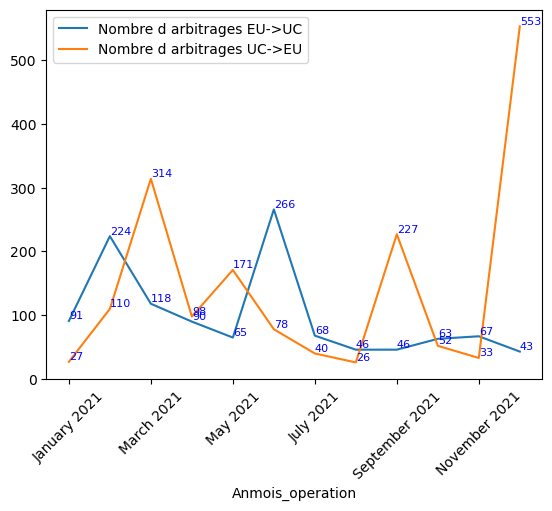

In [90]:
df=[Nb_contrat_mois_EU,Nb_contrat_mois_UC,Nb_contrat]
stat1 = df[0]
for df in df[1:]:
    stat1 = pd.merge(stat1, df, on='Anmois_operation', how='outer')
#Convertir la colonne Anmois_opération
from datetime import datetime
stat1['Anmois_operation'] = pd.to_datetime(stat1['Anmois_operation'], format='%Y%m')
stat1['Anmois_operation'] = stat1['Anmois_operation'].dt.strftime('%B %Y')
stat1['Anmois_operation'] = stat1['Anmois_operation'].astype(str)


stat1['Nombre d arbitrages UC->UC']=stat1['Nombre d arbitrages']-stat1['Nombre d arbitrages EU->UC']-stat1['Nombre d arbitrages UC->EU']
#Réorganisation des colonnes
stat1 = stat1[['Anmois_operation', 'Nombre d arbitrages EU->UC', 'Nombre d arbitrages UC->EU','Nombre d arbitrages UC->UC','Nombre d arbitrages']]
stat1= stat1.set_index('Anmois_operation')


M=stat1[['Nombre d arbitrages EU->UC','Nombre d arbitrages UC->EU']]
ax=M.plot()
plt.xticks(rotation=45)
for col in M.columns:
    for x, y in enumerate(M[col]):
        ax.text(x, y, str(y), color='blue', fontsize=8, verticalalignment='bottom')
plt.show()

In [77]:
stat1.loc['TOTAL'] = stat.sum()
stat2=stat1
stat1

,Nombre d arbitrages EU->UC,Nombre d arbitrages UC->EU,Nombre d arbitrages UC->UC,Nombre d arbitrages
Anmois_operation,,,,
January 2021,91,27,377,495
February 2021,224,110,235,569
March 2021,118,314,854,1286
April 2021,90,98,441,629
May 2021,65,171,322,558
June 2021,266,78,630,974
July 2021,68,40,256,364
August 2021,46,26,195,267
September 2021,46,227,350,623


 STATISTIQUES DU PORTEFEUILLE EN FONCTION DU MOUVEMENT SUR DANS LES SUPPORTS

### répartition en pourcentage

In [79]:
stat2['% EU->UC']=100*(stat2['Nombre d arbitrages EU->UC']/stat2['Nombre d arbitrages'])
stat2['% UC->EU']=100*(stat2['Nombre d arbitrages UC->EU']/stat2['Nombre d arbitrages'])
stat2['% UC->UC']=100*(stat2['Nombre d arbitrages UC->UC']/stat2['Nombre d arbitrages'])
stat2[['% EU->UC','% UC->EU','% UC->UC']].round(2)

,% EU->UC,% UC->EU,% UC->UC
Anmois_operation,,,
January 2021,18.38,5.45,76.16
February 2021,39.37,19.33,41.30
March 2021,9.18,24.42,66.41
April 2021,14.31,15.58,70.11
May 2021,11.65,30.65,57.71
June 2021,27.31,8.01,64.68
July 2021,18.68,10.99,70.33
August 2021,17.23,9.74,73.03
September 2021,7.38,36.44,56.18


## EVOLUTION DE L'ENCOURS SUR LES DIFFERENTS SUPPORTS

In [80]:
encours=base_multisupport[['n_sous','Anmois_operation','PM_UC','PM_FG','anciennete','age']]
contrat_encours=encours.groupby(by=['n_sous','Anmois_operation','PM_FG','PM_UC'], as_index=False).nunique()
contrat_encours=contrat_encours[['Anmois_operation','PM_FG','PM_UC']]
contrat_encours.rename(columns={'PM_FG': 'Encours support EU','PM_UC': 'Encours support UC'}, inplace=True)
#Convertir les données en valeur numériques 
contrat_encours[['Encours support EU', 'Encours support UC']] = contrat_encours[['Encours support EU', 'Encours support UC']].astype(float)
#Il est à noter que le contrat 9504 a des valeurs de PM_UC et PM_EU anormalement nulles
contrat_encours

,Anmois_operation,Encours support EU,Encours support UC
0,202102.0,129737.086302,0.000000
1,202104.0,10378.395674,97235.103280
2,202111.0,9214.572337,89112.482544
3,202105.0,327815.703177,460439.520124
4,202102.0,0.000000,170979.823211
...,...,...,...
8173,202108.0,70194.591957,0.000000
8174,202109.0,70194.591957,0.000000
8175,202110.0,70467.722665,0.000000
8176,202111.0,70467.722665,0.000000


### Evolution de l'encours d'épargne sur chaque support

In [81]:
contrat_encours_moy=contrat_encours.groupby(by=['Anmois_operation'], as_index=False).mean()
#covertion de la variable Anmois en format date
contrat_encours_moy['Anmois_operation'] =pd.to_datetime(contrat_encours_moy['Anmois_operation'], format='%Y%m')
contrat_encours_moy.sort_values(by='Anmois_operation')
contrat_encours_moy['Anmois_operation'] = contrat_encours_moy['Anmois_operation'].dt.strftime('%B %Y')
contrat_encours_moy['Anmois_operation'] = contrat_encours_moy['Anmois_operation'].astype(str)
contrat_encours_moy=contrat_encours_moy.set_index('Anmois_operation')

# calcul de l'encours moyen annuel sur chaque support
contrat_encours_moy.loc['ENSEMBLE']=contrat_encours_moy.mean()
X=contrat_encours_moy.round(2)
X

,Encours support EU,Encours support UC
Anmois_operation,,
January 2021,209912.97,215665.70
February 2021,197107.13,222539.11
March 2021,247137.42,222244.27
April 2021,227178.61,197246.66
May 2021,216289.41,232139.65
June 2021,209207.37,198938.06
July 2021,223336.54,252014.20
August 2021,172648.87,205237.37
September 2021,211612.63,214517.91


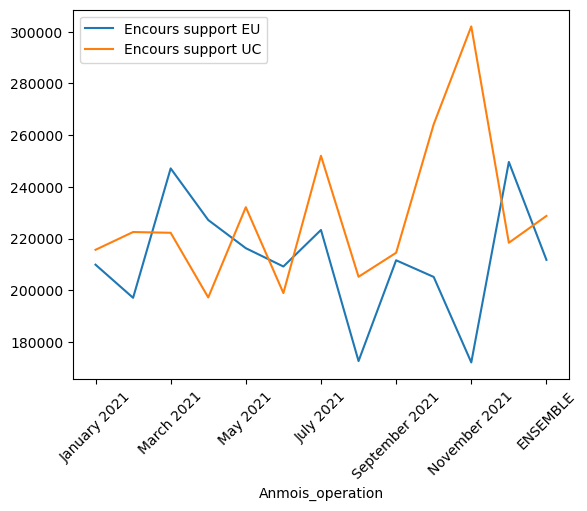

In [82]:
X[['Encours support EU','Encours support UC']].plot()
plt.xticks(rotation=45)
plt.show()

### Répartition en pourcentage

In [84]:
X['TOTAL']=X['Encours support EU']+X['Encours support UC']
X['% Encours support EU']=100*(X['Encours support EU']/X['TOTAL'])
X['% Encours support UC']=100*(X['Encours support UC']/X['TOTAL'])
Z=X[['% Encours support EU','% Encours support UC']].round(2)
Z

,% Encours support EU,% Encours support UC
Anmois_operation,,
January 2021,49.32,50.68
February 2021,46.97,53.03
March 2021,52.65,47.35
April 2021,53.53,46.47
May 2021,48.23,51.77
June 2021,51.26,48.74
July 2021,46.98,53.02
August 2021,45.69,54.31
September 2021,49.66,50.34


<function matplotlib.pyplot.show(close=None, block=None)>

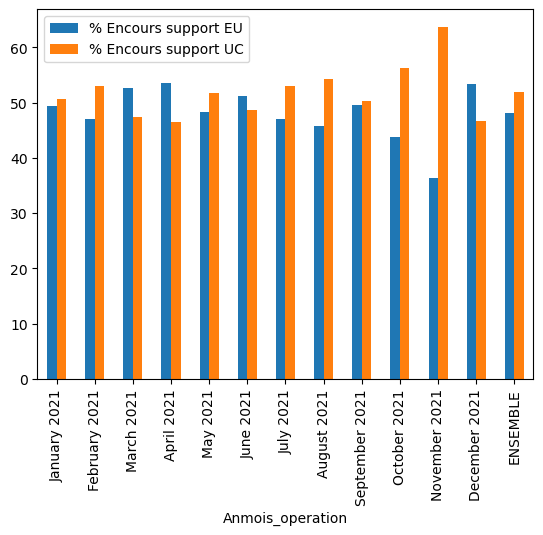

In [85]:
Z.plot(kind='bar')
plt.show

## Evolution des montants entrants et des montants sortants sur le fond en euro

### Montant sortant du FG

In [86]:
comptage
comptage['Anmois_operation'] =pd.to_datetime(comptage['Anmois_operation'], format='%Y%m')
comptage['Anmois_operation']=comptage['Anmois_operation'].dt.strftime('%B %Y')

C:\Users\oseez\AppData\Local\Temp\ipykernel_10992\112511174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comptage['Anmois_operation'] =pd.to_datetime(comptage['Anmois_operation'], format='%Y%m')
C:\Users\oseez\AppData\Local\Temp\ipykernel_10992\112511174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comptage['Anmois_operation']=comptage['Anmois_operation'].dt.strftime('%B %Y')


In [87]:
sortie_EU=comptage[comptage['operation']=='Arbitrages sortants du FG']
sortie_mois_EU = sortie_EU.groupby('Anmois_operation')['montant_corr'].sum()
sortie_mois_EU

Anmois_operation
April 2021       -3576324.66
August 2021      -1608089.47
December 2021    -3086238.80
February 2021    -5698473.71
January 2021     -3710163.86
July 2021        -2039011.86
June 2021        -3123403.68
March 2021       -4713379.32
May 2021         -2348432.77
November 2021    -1617298.16
October 2021     -2202704.45
September 2021    -996488.66
Name: montant_corr, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

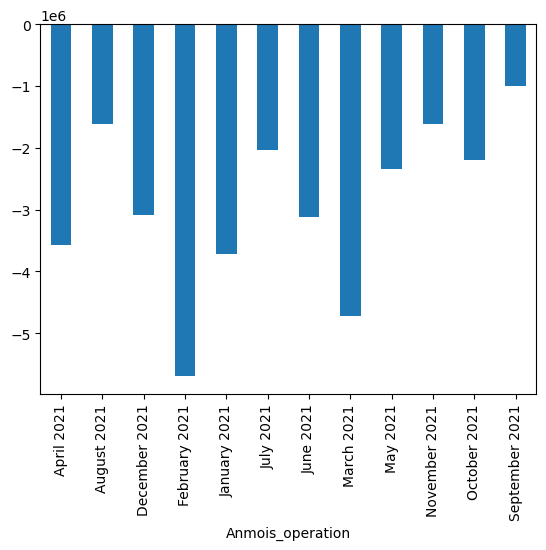

In [88]:
sortie_mois_EU.plot(kind='bar')
plt.show

### Montant entrants du FG

In [89]:
entrée_EU=comptage[comptage['operation']=='Arbitrages entrants du FG']
entrée_mois_EU = entrée_EU.groupby('Anmois_operation')['montant_corr'].sum()
entrée_mois_EU

Anmois_operation
April 2021        2423209.39
August 2021       1711674.98
December 2021     8456064.76
February 2021     1725482.92
January 2021      1471197.58
July 2021         6463142.23
June 2021         1582203.19
March 2021        4275176.28
May 2021          3539367.92
November 2021     1920286.03
October 2021      1638819.09
September 2021    4401315.91
Name: montant_corr, dtype: float64